<a href="https://colab.research.google.com/github/pooriaazami/deep_learning_class_notebooks/blob/main/8_Siamese_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files

In [ ]:
files.upload()

In [5]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d quadeer15sh/celeba-face-recognition-triplets

 98% 226M/231M [00:02<00:00, 82.8MB/s]
100% 231M/231M [00:02<00:00, 91.5MB/s]


In [7]:
!unzip celeba-face-recognition-triplets.zip

Streaming output truncated to the last 5000 lines.
  inflating: CelebA FR Triplets/CelebA FR Triplets/images/180490.jpg  
  inflating: CelebA FR Triplets/CelebA FR Triplets/images/180492.jpg  
  inflating: CelebA FR Triplets/CelebA FR Triplets/images/180495.jpg  
  inflating: CelebA FR Triplets/CelebA FR Triplets/images/180501.jpg  
  inflating: CelebA FR Triplets/CelebA FR Triplets/images/180515.jpg  
  inflating: CelebA FR Triplets/CelebA FR Triplets/images/180517.jpg  
  inflating: CelebA FR Triplets/CelebA FR Triplets/images/180518.jpg  
  inflating: CelebA FR Triplets/CelebA FR Triplets/images/180531.jpg  
  inflating: CelebA FR Triplets/CelebA FR Triplets/images/180532.jpg  
  inflating: CelebA FR Triplets/CelebA FR Triplets/images/180537.jpg  
  inflating: CelebA FR Triplets/CelebA FR Triplets/images/180539.jpg  
  inflating: CelebA FR Triplets/CelebA FR Triplets/images/180544.jpg  
  inflating: CelebA FR Triplets/CelebA FR Triplets/images/180547.jpg  
  inflating: CelebA FR Tri

In [8]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as T

from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [9]:
DATASET_ROOT = 'CelebA FR Triplets'
IMG_SIZE = 64
BATCH_SIZE = 8
EPOCHS = 1
LR = 1e-3
EMBEDDING_DIMENSION = 128
ALPHA = 1

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
class CelebADataset(Dataset):
  def __init__(self, root, transforms=None):
    self.__triplets = pd.read_csv(os.path.join(root, 'CelebA FR Triplets/triplets.csv'))
    self.__images_path = os.path.join(root, 'CelebA FR Triplets/images')

    self.__transforms = transforms

  def __read_image(self, image_path):
    img = os.path.join(self.__images_path, image_path)
    img = Image.open(img)

    return img

  def __getitem__(self, idx):
    anchor, _, pos, _, neg, _ = self.__triplets.iloc[idx]

    anchor_img = self.__read_image(anchor)
    pos_img = self.__read_image(pos)
    neg_img = self.__read_image(neg)

    if self.__transforms:
      anchor_img = self.__transforms(anchor_img)
      pos_img = self.__transforms(pos_img)
      neg_img = self.__transforms(neg_img)

    return anchor_img, pos_img, neg_img

  def __len__(self):
    return self.__triplets.shape[0]

In [11]:
dataset = CelebADataset(DATASET_ROOT)

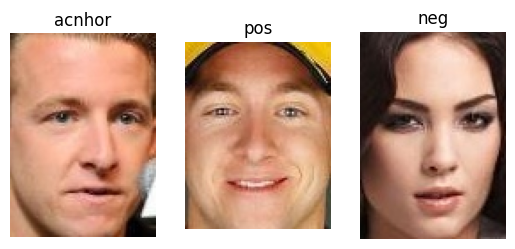

In [12]:
idx = 0
anchor, pos, neg = dataset[idx]

fig, axs = plt.subplots(1, 3)

axs[0].imshow(anchor)
axs[0].set_title('acnhor')
axs[0].axis('off')

axs[1].imshow(pos)
axs[1].set_title('pos')
axs[1].axis('off')

axs[2].imshow(neg)
axs[2].set_title('neg')
axs[2].axis('off')

plt.show()

In [13]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.layers = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.BatchNorm2d(num_features=out_channels)
    )

  def forward(self, x):
    return self.layers(x)

In [14]:
class SiameseNetwork(nn.Module):
  def __init__(self, embedding_dimension, conv_filters):
    super().__init__()

    flattened_conv_shapes = (IMG_SIZE // 2 ** (len(conv_filters))) ** 2 * conv_filters[-1]
    conv_filters = [3] + conv_filters

    self.conv_fileters = nn.Sequential(
        *[ConvBlock(conv_filters[i], conv_filters[i+1]) for i in range(len(conv_filters)-1)]
    )

    self.linear_layers = nn.Sequential(
        nn.Linear(in_features=flattened_conv_shapes, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=embedding_dimension),
    )

  def forward(self, x):
    x = self.conv_fileters(x)
    x = x.flatten(1)
    x = self.linear_layers(x)
    return x

In [15]:
transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor()
])

dataset = CelebADataset(DATASET_ROOT, transforms)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
conv_filters = [16, 32, 64]

model = SiameseNetwork(EMBEDDING_DIMENSION, conv_filters).to(DEVICE)

In [17]:
optimizer = optim.Adam(model.parameters(), lr=LR)

In [18]:
def triplet_loss(anchor, pos, neg):
  loss_value = torch.linalg.norm(anchor - pos) ** 2 - torch.linalg.norm(anchor - neg) ** 2 + ALPHA
  loss_value = torch.maximum(loss_value, torch.zeros_like(loss_value))
  loss_value = torch.mean(loss_value)
  return loss_value

In [19]:
for i in range(1, EPOCHS + 1):
  total_loss = .0

  print(f'Epoch {i}')
  for anchor, pos, neg in tqdm(data_loader):
    optimizer.zero_grad()

    anchor = anchor.to(DEVICE)
    pos = pos.to(DEVICE)
    neg = neg.to(DEVICE)

    anchor_embeddings = model(anchor)
    pos_emneddings = model(pos)
    neg_embeddings = model(neg)

    loss = triplet_loss(anchor_embeddings, pos_emneddings, neg_embeddings)
    loss.backward()
    optimizer.step()

    total_loss += loss.detach().cpu().item()

  print(f'loss: {total_loss:.2f}')

Epoch 1


  0%|          | 0/2042 [00:00<?, ?it/s]

loss: 61091.36
